In [2]:
import os
import sys
import copy
pdir = os.path.dirname(os.getcwd())
sys.path.append(pdir)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import wandb
import random
import seaborn as sns
sns.set(rc={'text.usetex' : True})

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix, accuracy_score

import utils
from simpleview_pytorch import SimpleView

from torch.utils.data.dataset import Dataset
#foo

In [3]:
dataset_dir = 'tree_points.pt'
model_dir = 'models/1ru3sr8i'
model_dir_b = model_dir + "_best"
model_dir_c = model_dir + "_converged"
model_dir_p = model_dir + "_best_prod"

In [ ]:
logits_b, labels_b, predictions_b, val_species = utils.predict_from_dirs(dataset_dir, model_dir_b)
logits_c, labels_c, predictions_c, val_species = utils.predict_from_dirs(dataset_dir, model_dir_c)
logits_p, labels_p, predictions_p, val_species = utils.predict_from_dirs(dataset_dir, model_dir_p)

Removing: DEAD
Removing: JUNIPE
Removing: QUERCUS
Removing: NA
Removing: DEAD
Removing: JUNIPE
Removing: QUERCUS
Removing: NA


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,9))

tickFont = 20
axFont = 36
annotFont = 24

print(val_species)
val_species = ['P. Nigra', 'P. Pinaster', 'P. Sylvestris', 'Q. Faginea', 'Q. Ilex']

cm1 = confusion_matrix(labels_b.cpu(), predictions_b.cpu(), normalize='true')
hm1 = sns.heatmap(cm1, annot=True, ax=ax[0], cbar=False, annot_kws={"fontsize":annotFont})
hm1.set_xticklabels(val_species, fontsize=tickFont)
ax[0].set_yticklabels(val_species, fontsize=tickFont)
hm1.set_ylabel('True Labels', fontsize=axFont+2)
hm1.set_xlabel('Predictions - Best Overall Model', fontsize=axFont)


cm2 = confusion_matrix(labels_c.cpu(), predictions_c.cpu(), normalize='true')
hm2 = sns.heatmap(cm2, annot=True, ax=ax[1], cbar=False, annot_kws={"fontsize":annotFont})
hm2.set_xticklabels(val_species, fontsize=tickFont)
hm2.set_yticklabels(val_species, fontsize=tickFont)
hm2.set_ylabel('', fontsize=axFont)
hm2.set_xlabel('Predictions - Best Converged Model', fontsize=axFont)

cm3 = confusion_matrix(labels_p.cpu(), predictions_p.cpu(), normalize='true')
hm3 = sns.heatmap(cm3, annot=True, ax=ax[2], cbar=False, annot_kws={"fontsize":annotFont})
hm3.set_xticklabels(val_species, fontsize=tickFont)
hm3.set_yticklabels(val_species, fontsize=tickFont)
hm3.set_ylabel('', fontsize=axFont)
hm3.set_xlabel('Predictions - Best Producer Accuracy', fontsize=axFont)

for ax in fig.axes:
    plt.sca(ax)
    plt.yticks(rotation=90)

fig.savefig('baseline.png', bbox_inches='tight')

# Rotation Voting ===========

## Sweep

In [7]:
accuracies = {}
rotations = [64]
max_rotation = 0.5*np.pi

for model in ["best"]:
    accuracies[model] = {"soft":[],"hard":[]}
    for num_rotations in rotations:
        print(f"{model}_{num_rotations}")
        soft_predictions, hard_predictions, labels, species = utils.rot_vot_from_dirs(dataset_dir,
                                                                               model_dir=f"{model_dir}_{model}",
                                                                               num_rotations=num_rotations,
                                                                               max_rotation=max_rotation)
        accuracies[model]["soft"].append(accuracy_score(labels.cpu(), soft_predictions.cpu()))
        accuracies[model]["hard"].append(accuracy_score(labels.cpu(), hard_predictions.cpu()))

if None:
    with open(f'rot_{max_rotation:.2f}_acc.pickle', 'wb') as handle:
        pickle.dump(accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)

best_64
Removing: NA
Removing: DEAD
Removing: JUNIPE
Removing: QUERCUS


['P. Nigra', 'P. Pinaster', 'P. Sylvestris', 'Q. Faginea', 'Q. Ilex']


Text(0.5, 57.75875865893524, 'Predictions - Best Overall w/ 64 Hard Rotation Votes')

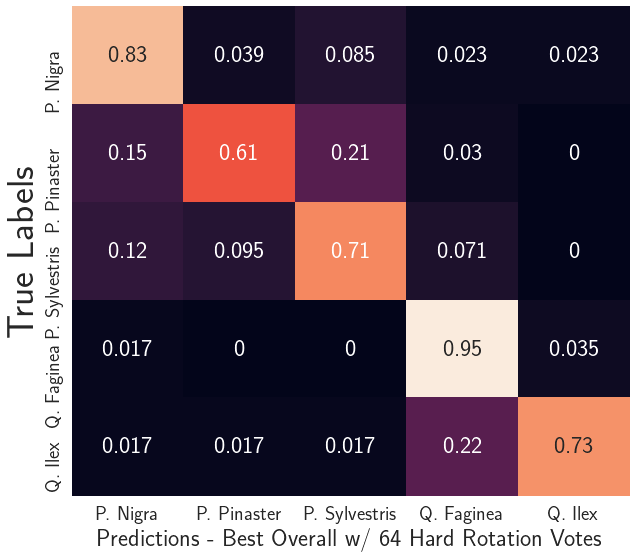

In [11]:
fig_rot, ax_rot = plt.subplots(figsize=(10,9))

tickFont = 20
axFont = 36
annotFont = 24

print(val_species)
val_species = ['P. Nigra', 'P. Pinaster', 'P. Sylvestris', 'Q. Faginea', 'Q. Ilex']

cm_rot = confusion_matrix(labels.cpu(), hard_predictions.cpu(), normalize='true')
hm_rot = sns.heatmap(cm_rot, annot=True, ax=ax_rot, cbar=False, annot_kws={"fontsize":annotFont})
hm_rot.set_xticklabels(val_species, fontsize=tickFont)
ax_rot.set_yticklabels(val_species, fontsize=tickFont)
hm_rot.set_ylabel('True Labels', fontsize=axFont+2)
hm_rot.set_xlabel('Predictions - Best Overall w/ 64 Hard Rotation Votes', fontsize=axFont-12)

In [12]:
accuracies_tmp = {'best': {'soft': [0.8303030303030303,
   0.8363636363636363,
   0.8383838383838383,
   0.8464646464646465,
   0.8444444444444444,
   0.8444444444444444,
   0.8464646464646465],
  'hard': [0.8303030303030303,
   0.8262626262626263,
   0.8222222222222222,
   0.8444444444444444,
   0.8464646464646465,
   0.8464646464646465,
   0.8484848484848485]},
 'converged': {'soft': [0.8101010101010101,
   0.8121212121212121,
   0.8101010101010101,
   0.8121212121212121,
   0.8181818181818182,
   0.8161616161616162,
   0.8161616161616162],
  'hard': [0.8101010101010101,
   0.806060606060606,
   0.8121212121212121,
   0.8181818181818182,
   0.8141414141414142,
   0.8181818181818182,
   0.8181818181818182]},
 'best_prod': {'soft': [0.8222222222222222,
   0.8121212121212121,
   0.8181818181818182,
   0.8161616161616162,
   0.8141414141414142,
   0.8121212121212121,
   0.8161616161616162],
  'hard': [0.8222222222222222,
   0.8242424242424242,
   0.8161616161616162,
   0.8101010101010101,
   0.8161616161616162,
   0.8161616161616162,
   0.8222222222222222]}}

In [4]:
import pickle
with open('rot_acc.pkl', 'wb') as handle:
    acc = pickle.load('rot_acc.pkl')

TypeError: file must have 'read' and 'readline' attributes